In [1]:

#######################################################
#######################################################
############    COPYRIGHT - DATA SOCIETY   ############
#######################################################
#######################################################

## 13 ADVANCED CLASSIFICATION DAY6 ##

## NOTE: To run individual pieces of code, select the line of code and
##       press ctrl + enter for PCs or command + enter for Macs



In [2]:
#=================================================-
#### Slide 7: Directory settings  ####




###  installs
 - conda install -c conda-forge wordcloud
 - conda install -c conda-forge scikit-surprise
 - then log out from terminal and come back

## new package references

### word cloud
https://amueller.github.io/word_cloud/

https://python-graph-gallery.com/wordcloud/

https://github.com/amueller/word_cloud

https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html

#### surprise - recommender systems
http://surpriselib.com/

https://surprise.readthedocs.io/en/stable/index.html

https://github.com/NicolasHug/Surprise


In [3]:
#=================================================-
#### Slide 8: Loading the packages  ####

import os
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.sparse.linalg import svds
from surprise import Reader, Dataset, SVD, model_selection

In [4]:
#=================================================-
#### Slide 9: Working directory  ####
nb_root=globals()['_dh']
os.chdir(nb_root[0])

main_dir = os.path.abspath(os.path.join ("..",))

# Make `data_dir` and 'path_dir' from the `main_dir` and
data_dir = os.path.join(main_dir, "data")
plot_dir = os.path.join(main_dir, "plot")

# Set working directory.
os.chdir(data_dir)
# Check working directory.
print(os.getcwd())



/Users/datasociety/Desktop/af-werx/data


In [5]:
#=================================================-
#### Slide 10: Load the dataset and check the structure  ####

# Reading the ratings file.
os.chdir(data_dir)
ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1',
usecols = ['user_id', 'movie_id', 'rating'])

# Reading users file.
users = pd.read_csv('users.csv', sep='\t', encoding='latin-1',
usecols = ['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file.
movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1',
usecols = ['movie_id', 'title', 'genres'])

print(ratings.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
user_id     1000209 non-null int64
movie_id    1000209 non-null int64
rating      1000209 non-null int64
dtypes: int64(3)
memory usage: 22.9 MB
None


In [6]:
#=================================================-
#### Slide 11: Load the dataset and check the structure  ####

print(users.info())

print(movies.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
user_id     6040 non-null int64
gender      6040 non-null object
zipcode     6040 non-null object
age_desc    6040 non-null object
occ_desc    6040 non-null object
dtypes: int64(1), object(4)
memory usage: 236.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
movie_id    3883 non-null int64
title       3883 non-null object
genres      3883 non-null object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB
None


In [7]:
#=================================================-
#### Slide 12: View the head of the dataset  ####

ratings.head(3)


,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3


In [8]:
users.head(3)

,user_id,gender,zipcode,age_desc,occ_desc
0,1,F,48067,Under 18,K-12 student
1,2,M,70072,56+,self-employed
2,3,M,55117,25-34,scientist


In [9]:
movies.head(3)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


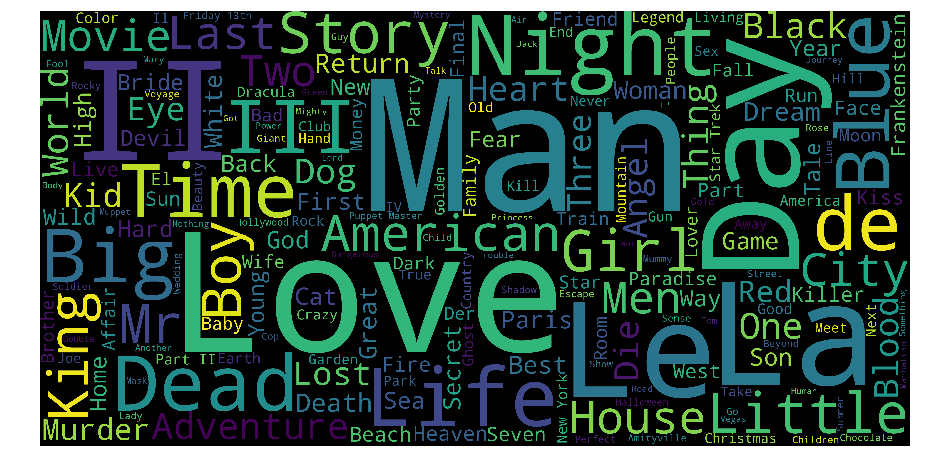

In [10]:
#=================================================-
#### Slide 13: Movies - data exploration  ####

# Create a word cloud of the movie titles.
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords = STOPWORDS,
                            background_color = 'black',
                            height = 2000, 
                            width = 4000).generate(title_corpus)

# Plot the word cloud.
plt.figure(figsize = (16, 8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()



count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


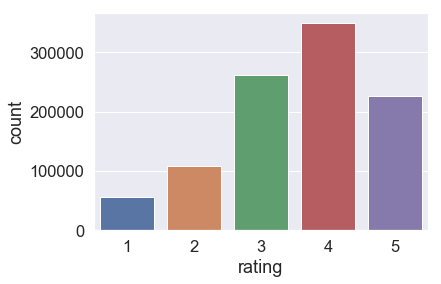

In [11]:
#=================================================-
#### Slide 14: Ratings - data exploration  ####

# Get summary statistics of ratings.
print(ratings['rating'].describe())
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Display distribution of ratings.
sns.countplot(ratings['rating'])



In [12]:
#=================================================-
#### Slide 15: Combining dataframes  ####

# Join all 3 files into one dataframe.
dataset = pd.merge(pd.merge(movies, ratings), users)

# Display 5 movies with highest ratings.
print(dataset[['title', 'genres', 'rating']].sort_values('rating', ascending = False).head(5))
# Make a census of the genre keywords.
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))



                         title                       genres  rating
0             Toy Story (1995)  Animation|Children's|Comedy       5
489283  American Beauty (1999)                 Comedy|Drama       5
489259         Election (1999)                       Comedy       5
489257      Matrix, The (1999)       Action|Sci-Fi|Thriller       5
489256     Dead Ringers (1988)               Drama|Thriller       5


In [13]:
#=================================================-
#### Slide 16: Function to count the genres  ####

# Create a function that counts the number of times each of the genre keywords appear.
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census:
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):
        if type(census_keywords) == float and pd.isnull(census_keywords):
            continue
        for s in [s for s in census_keywords if s in census]:
            if pd.notnull(s):
                keyword_count[s] += 1

    # Convert the dictionary in a list to sort the keywords by frequency.
    keyword_occurrences = []
    for k,v in keyword_count.items():
        keyword_occurrences.append([k,v])
    keyword_occurrences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurrences, keyword_count


In [14]:
# Calling this function gives access to a list of genre keywords, which are sorted by decreasing frequency.
keyword_occurrences, dum = count_word(movies, 'genres', genre_labels)
print(keyword_occurrences[:5])


[['Drama', 1603], ['Comedy', 1200], ['Action', 503], ['Thriller', 492], ['Romance', 471]]


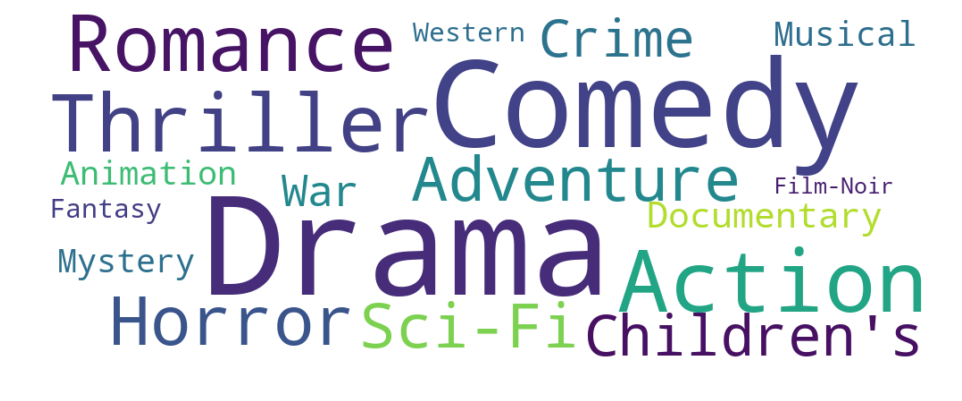

In [15]:
#=================================================-
#### Slide 17: Word cloud for genres  ####

# Define the dictionary used to produce the genre word cloud.
genres = dict()
trunc_occurrences = keyword_occurrences[0:18]
for s in trunc_occurrences:
    genres[s[0]] = s[1]

# Create the word cloud.
genre_wordcloud = WordCloud(width = 1000, height = 400, background_color = 'white')
genre_wordcloud.generate_from_frequencies(genres)


# Plot the word cloud.
f, ax = plt.subplots(figsize = (16, 8))
plt.imshow(genre_wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()



In [16]:
#=================================================-
#### Slide 19: Exercise 1  ####





In [17]:
#=================================================-
#### Slide 26: Content based recommender implementation  ####

### this is a good explanation of TF-IDF
## https://courses.cs.washington.edu/courses/cse373/17au/project3/project3-2.html

# Break up the big genre string into a string array.
movies['genres'] = movies['genres'].str.split('|')

# Convert genres to string values.
movies['genres'] = movies['genres'].fillna("").astype('str')
print(movies['genres'].head())
tf = TfidfVectorizer(analyzer = 'word',
                     ngram_range = (1, 2),
                     min_df = 0,
                     stop_words = 'english')

tfidf_matrix = tf.fit_transform(movies['genres'])
print(tfidf_matrix.shape)



0     ['Animation', "Children's", 'Comedy']
1    ['Adventure', "Children's", 'Fantasy']
2                     ['Comedy', 'Romance']
3                       ['Comedy', 'Drama']
4                                ['Comedy']
Name: genres, dtype: object
(3883, 127)


In [18]:
#=================================================-
#### Slide 27: Content based recommender implementation  ####

# Cosine similarity for all movies, and look at the first four rows and columns.
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim[:4, :4])

print(cosine_sim.shape)

# Build a 1-dimensional array with movie titles.
titles = movies['title']
indices = pd.Series(movies.index, index = movies['title'])
print(titles[0:5])



[[1.         0.14193614 0.09010857 0.1056164 ]
 [0.14193614 1.         0.         0.        ]
 [0.09010857 0.         1.         0.1719888 ]
 [0.1056164  0.         0.1719888  1.        ]]
(3883, 3883)
0                      Toy Story (1995)
1                        Jumanji (1995)
2               Grumpier Old Men (1995)
3              Waiting to Exhale (1995)
4    Father of the Bride Part II (1995)
Name: title, dtype: object


In [19]:
#=================================================-
#### Slide 28: Content based recommender implementation  ####

# Function that get movie recommendations based on the cosine similarity score of movie genres.
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [20]:
## investigate the function - here we get movie number and a single similarity summary

idx = indices['Toy Story (1995)']
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores[1:5]

[(1, 0.14193613540291974),
 (2, 0.09010857273968623),
 (3, 0.10561639781314143),
 (4, 0.23523321955508567)]

In [21]:
# sort by similarity and take the top ones
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:21]
sim_scores

#movie_indices = [i[0] for i in sim_scores]
#return titles.iloc[movie_indices]

[(1050, 0.9999999999999998),
 (2072, 0.9999999999999998),
 (2073, 0.9999999999999998),
 (2285, 0.9999999999999998),
 (2286, 0.9999999999999998),
 (3045, 0.9999999999999998),
 (3542, 0.9999999999999998),
 (3682, 0.9999999999999998),
 (3685, 0.9999999999999998),
 (236, 0.869805172759514),
 (12, 0.8268110689140029),
 (241, 0.8268110689140029),
 (310, 0.8268110689140029),
 (592, 0.8268110689140029),
 (612, 0.8268110689140029),
 (700, 0.8268110689140029),
 (876, 0.8268110689140029),
 (1010, 0.8268110689140029),
 (1012, 0.8268110689140029),
 (1020, 0.8268110689140029)]

In [22]:
# look up and print
movie_indices = [i[0] for i in sim_scores]
movie_indices 

[1050,
 2072,
 2073,
 2285,
 2286,
 3045,
 3542,
 3682,
 3685,
 236,
 12,
 241,
 310,
 592,
 612,
 700,
 876,
 1010,
 1012,
 1020]

In [23]:
titles.iloc[movie_indices]

1050               Aladdin and the King of Thieves (1996)
2072                             American Tail, An (1986)
2073           American Tail: Fievel Goes West, An (1991)
2285                            Rugrats Movie, The (1998)
2286                                 Bug's Life, A (1998)
3045                                   Toy Story 2 (1999)
3542                                Saludos Amigos (1943)
3682                                   Chicken Run (2000)
3685       Adventures of Rocky and Bullwinkle, The (2000)
236                                 Goofy Movie, A (1995)
12                                           Balto (1995)
241                               Gumby: The Movie (1995)
310                             Swan Princess, The (1994)
592                                      Pinocchio (1940)
612                                Aristocats, The (1970)
700                               Oliver & Company (1988)
876     Land Before Time III: The Time of the Great Gi...
1010          

In [24]:
#=================================================-
#### Slide 29: Content based recommender implementation  ####

print(genre_recommendations('Toy Story (1995)').head(20))

1050               Aladdin and the King of Thieves (1996)
2072                             American Tail, An (1986)
2073           American Tail: Fievel Goes West, An (1991)
2285                            Rugrats Movie, The (1998)
2286                                 Bug's Life, A (1998)
3045                                   Toy Story 2 (1999)
3542                                Saludos Amigos (1943)
3682                                   Chicken Run (2000)
3685       Adventures of Rocky and Bullwinkle, The (2000)
236                                 Goofy Movie, A (1995)
12                                           Balto (1995)
241                               Gumby: The Movie (1995)
310                             Swan Princess, The (1994)
592                                      Pinocchio (1940)
612                                Aristocats, The (1970)
700                               Oliver & Company (1988)
876     Land Before Time III: The Time of the Great Gi...
1010          

In [25]:
#=================================================-
#### Slide 30: Generate content-based recommendation  ####

print(genre_recommendations('Assassins (1995)').head(20))



22                      Assassins (1995)
101                 Unforgettable (1996)
130                          Jade (1995)
181                  Mute Witness (1994)
188                          Safe (1995)
198           Tie That Binds, The (1995)
223                     Dream Man (1995)
237                      Hideaway (1995)
288                 Poison Ivy II (1995)
316                 Shallow Grave (1994)
369                 Red Rock West (1992)
418                         Blink (1994)
478                   Killing Zoe (1994)
486                        Malice (1993)
536                        Sliver (1993)
550                 Trial by Jury (1994)
557    Killer (Bulletproof Heart) (1994)
575                    Scorta, La (1993)
596                Love and a .45 (1994)
656                          Fear (1996)
Name: title, dtype: object


In [26]:
#=================================================-
#### Slide 31: Generate content-based recommendation  ####

print(genre_recommendations('Sense and Sensibility (1995)').head(20))



24                              Leaving Las Vegas (1995)
34                                     Carrington (1995)
45                  How to Make an American Quilt (1995)
48                          When Night Is Falling (1995)
57                      Postino, Il (The Postman) (1994)
73                                   Bed of Roses (1996)
84                             Angels and Insects (1995)
103                Bridges of Madison County, The (1995)
129                             Frankie Starlight (1995)
138                         Up Close and Personal (1996)
177                                      Mad Love (1995)
180                       Moonlight and Valentino (1995)
200                                 Total Eclipse (1995)
205                         Walk in the Clouds, A (1995)
213                                Before Sunrise (1995)
219                             Circle of Friends (1995)
246                              Immortal Beloved (1994)
262    Like Water for Chocolate

In [27]:
#=================================================-
#### Slide 34: Exercise 2  ####





In [28]:
#=================================================-
#### Slide 41: Load the subset of data  ####

os.chdir(data_dir)

# Read in the datasets.
rating_subset = pd.read_csv('ratings-subset.csv')
movies_subset = pd.read_csv('movies-subset.csv')

# Select only movie ID and title from movies dataset.
movies_subset = movies_subset[['movieId', 'title']]

# Merge both ratings and movies dataframes.
rating_df = pd.merge(movies_subset, rating_subset)

# View the summary and head of the merged dataframe.

print(rating_subset.head())
print(movies_subset.head())
print(rating_df.head())

print(rating_subset.shape)
print(movies_subset.shape)
print(rating_df.shape)
#print(rating_df.userId.unique())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   movieId                               title
0        1                    Toy Story (1995)
1        2                      Jumanji (1995)
2        3             Grumpier Old Men (1995)
3        4            Waiting to Exhale (1995)
4        5  Father of the Bride Part II (1995)
   movieId             title  userId  rating   timestamp
0        1  Toy Story (1995)       1     4.0   964982703
1        1  Toy Story (1995)       5     4.0   847434962
2        1  Toy Story (1995)       7     4.5  1106635946
3        1  Toy Story (1995)      15     2.5  1510577970
4        1  Toy Story (1995)      17     4.5  1305696483
(100836, 4)
(9742, 2)
(100836, 5)


In [29]:
#=================================================-
#### Slide 42: Item based recommender implementation  ####

userRating = rating_df.pivot_table(index = ['userId'],
                                   columns = ['title'],
                                   values = 'rating')

print(userRating.shape)
userRating.head()

(610, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
#=================================================-
#### Slide 43: Item correlation matrix  ####

corrMatrix = userRating.corr(method = 'pearson', min_periods = 100)
corrMatrix.to_csv('corrMatrix.csv', index = True, encoding = 'utf-8')

os.chdir(data_dir)
corrMatrix = pd.read_csv('corrMatrix.csv')

print(corrMatrix.head())

corrMatrix = corrMatrix.set_index('title')



                                     title  '71 (2014)  \
0                               '71 (2014)         NaN   
1  'Hellboy': The Seeds of Creation (2004)         NaN   
2                   'Round Midnight (1986)         NaN   
3                      'Salem's Lot (2004)         NaN   
4                'Til There Was You (1997)         NaN   

   'Hellboy': The Seeds of Creation (2004)  'Round Midnight (1986)  \
0                                      NaN                     NaN   
1                                      NaN                     NaN   
2                                      NaN                     NaN   
3                                      NaN                     NaN   
4                                      NaN                     NaN   

   'Salem's Lot (2004)  'Til There Was You (1997)  \
0                  NaN                        NaN   
1                  NaN                        NaN   
2                  NaN                        NaN   
3                 

In [31]:
# select rows that are not null - this takes way too long! the matrix is very sparse
#corrMatrix[~corrMatrix.iloc[:, 0:2].isnull()]

KeyboardInterrupt: 

In [32]:
#=================================================-
#### Slide 45: Suggest movies to user  ####

user_corr = pd.Series()

user_id = 27

# Create a list of all films with all correlations multiplied by the rating.
for film in userRating.iloc[user_id].dropna().index:
    corr_list = corrMatrix[film].dropna() * userRating.iloc[user_id][film]
    user_corr = user_corr.append(corr_list)

# Group by movie ID and sum the ratings to remove duplicates.
user_corr = user_corr.groupby(user_corr.index).sum()



In [33]:
#=================================================-
#### Slide 46: Suggest movies to user  ####

# Create a list of movies the user has already seen and remove them.
title_list = []

for i in range(len(userRating.iloc[user_id].dropna().index)):
    if userRating.iloc[user_id].dropna().index[i] in user_corr:
        title_list.append(userRating.iloc[user_id].dropna().index[i])
    else:
        pass
    
user_corr = user_corr.drop(title_list)



In [34]:
#=================================================-
#### Slide 47: Suggest movies to user  ####

print('Hi! Based on the films that you have seen, you might like: \n')

for i in userRating.iloc[user_id].dropna().index:
    print(i)

# Suggest the top 10 movies.

print('\n I would suggest that you watch: \n')

for i in user_corr.sort_values(ascending = False).index[:10]:
    print(i)



Hi! Based on the films that you have seen, you might like: 

10,000 BC (2008)
1408 (2007)
16 Blocks (2006)
2001: A Space Odyssey (1968)
2012 (2009)
21 (2008)
21 Grams (2003)
28 Days Later (2002)
300 (2007)
3:10 to Yuma (2007)
A.I. Artificial Intelligence (2001)
AVP: Alien vs. Predator (2004)
About Schmidt (2002)
Absolute Power (1997)
Adventures of Priscilla, Queen of the Desert, The (1994)
Aeon Flux (2005)
Air Force One (1997)
Alexander (2004)
Ali (2001)
Alien (1979)
Aliens (1986)
Alive (1993)
All the King's Men (2006)
Along Came a Spider (2001)
Alpha Dog (2007)
Amazing Grace (2006)
American Beauty (1999)
American Gangster (2007)
American History X (1998)
American Pie (1999)
American Psycho (2000)
Analyze This (1999)
Anchorman: The Legend of Ron Burgundy (2004)
Animal Crackers (1930)
Animal Factory (2000)
Annie Hall (1977)
Antwone Fisher (2002)
Any Given Sunday (1999)
Apocalypse Now (1979)
Appaloosa (2008)
Army of Darkness (1993)
Assassination of Jesse James by the Coward Robert Ford, 

In [ ]:
#=================================================-
#### Slide 49: Exercise 3  ####





In [35]:
#=================================================-
#### Slide 56: Find total users and movies  ####

# Find total number of unique users and movies.
n_users = ratings.user_id.unique().shape[0]
n_movies = ratings.movie_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))



Number of users = 6040 | Number of movies = 3706


In [38]:
#=================================================-
#### Slide 57: Data preparation for SVD  ####

Ratings = ratings.pivot(index = 'user_id',
                        columns = 'movie_id',
                        values = 'rating').fillna(0)
Ratings.head()



movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
#=================================================-
#### Slide 58: De-normalize the data and check the amount of sparsity  ####

warnings.filterwarnings("ignore", category = FutureWarning)
# Normalize the data.
R = Ratings.as_matrix()

user_ratings_mean = np.mean(R, axis = 1)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)

# Check the percentage of sparsity.
sparsity = round(1.0 - len(ratings) / float(n_users * n_movies), 3)
print('The sparsity level of MovieLens1M dataset is ' +  str(sparsity * 100) + '%')



The sparsity level of MovieLens1M dataset is 95.5%


In [39]:
#=================================================-
#### Slide 59: SVD implementation  ####

U, sigma, Vt = svds(Ratings_demeaned, k = 50)

# Convert the sigma matrix to the diagonal matrix form.
sigma = np.diag(sigma)



In [41]:
#=================================================-
#### Slide 60: SVD implementation  ####

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)



In [43]:
#=================================================-
#### Slide 61: SVD implementation  ####

preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()



movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.288861,0.143055,-0.195080,-0.018843,0.012232,-0.176604,-0.074120,0.141358,-0.059553,-0.195950,...,0.027807,0.001640,0.026395,-0.022024,-0.085415,0.403529,0.105579,0.031912,0.050450,0.088910
1,0.744716,0.169659,0.335418,0.000758,0.022475,1.353050,0.051426,0.071258,0.161601,1.567246,...,-0.056502,-0.013733,-0.010580,0.062576,-0.016248,0.155790,-0.418737,-0.101102,-0.054098,-0.140188
2,1.818824,0.456136,0.090978,-0.043037,-0.025694,-0.158617,-0.131778,0.098977,0.030551,0.735470,...,0.040481,-0.005301,0.012832,0.029349,0.020866,0.121532,0.076205,0.012345,0.015148,-0.109956
3,0.408057,-0.072960,0.039642,0.089363,0.041950,0.237753,-0.049426,0.009467,0.045469,-0.111370,...,0.008571,-0.005425,-0.008500,-0.003417,-0.083982,0.094512,0.057557,-0.026050,0.014841,-0.034224
4,1.574272,0.021239,-0.051300,0.246884,-0.032406,1.552281,-0.199630,-0.014920,-0.060498,0.450512,...,0.110151,0.046010,0.006934,-0.015940,-0.050080,-0.052539,0.507189,0.033830,0.125706,0.199244


In [46]:
#=================================================-
#### Slide 62: SVD implementation  ####

def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    # Get and sort the user's predictions.
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending = False) # User ID starts at 1
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.user_id == (userID)]
    user_full = (user_data.merge(movies, how = 'left',
                                 left_on = 'movie_id', 
                                 right_on = 'movie_id').sort_values(['rating'], 
                                                                    ascending=False))

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movie_id'].isin(user_full['movie_id'])].merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
                                                                                     left_on = 'movie_id', 
                                                                                     right_on = 'movie_id').rename(
        columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :-1])

    return user_full, recommendations



In [47]:
#=================================================-
#### Slide 63: Recommend movies using SVD  ####

already_rated, predictions = recommend_movies(preds, 1310, movies, ratings, 20)



User 1310 has already rated 24 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [48]:
#=================================================-
#### Slide 64: Recommend movies using SVD  ####

# Top 20 movies that User 1310 has rated.
print(already_rated[['user_id', 'title']])



    user_id                                              title
5      1310                             Say Anything... (1989)
6      1310                           This Is My Father (1998)
7      1310                                Blood Simple (1984)
15     1310                           Good Will Hunting (1997)
1      1310                                      Gandhi (1982)
12     1310                            Fatal Attraction (1987)
11     1310                                   Cape Fear (1991)
20     1310                               Lethal Weapon (1987)
18     1310                                  Parenthood (1989)
17     1310                                    Hoosiers (1986)
13     1310                         Places in the Heart (1984)
23     1310                  E.T. the Extra-Terrestrial (1982)
10     1310  Star Wars: Episode V - The Empire Strikes Back...
9      1310                                My Left Foot (1989)
8      1310                              Prizzi's Honor

In [49]:
#=================================================-
#### Slide 65: Recommend movies using SVD  ####

# Top 20 movies that User 1310 hopefully will enjoy.
print(predictions[['movie_id', 'title']])



      movie_id                                              title
1618      1674                                     Witness (1985)
1880      1961                                    Rain Man (1988)
1187      1210  Star Wars: Episode VI - Return of the Jedi (1983)
1216      1242                                       Glory (1989)
1202      1225                                     Amadeus (1984)
1273      1302                             Field of Dreams (1989)
1220      1246                          Dead Poets Society (1989)
1881      1962                          Driving Miss Daisy (1989)
1877      1957                            Chariots of Fire (1981)
1938      2020                          Dangerous Liaisons (1988)
1233      1259                                 Stand by Me (1986)
3011      3098                                Natural, The (1984)
2112      2194                           Untouchables, The (1987)
1876      1956                             Ordinary People (1980)
1268      

In [52]:
#=================================================-
#### Slide 68: Model evaluation  ####

# Load Reader library.
reader = Reader()

# Load ratings dataset with the Dataset library.
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

# Split the dataset for 5-fold evaluation.
#data.split(n_folds = 5)



In [53]:
#=================================================-
#### Slide 69: Model evaluation  ####

# Use the SVD algorithm.
svd = SVD()
# Compute the RMSE of the SVD algorithm.
#evaluate_model = evaluate(svd, data, measures=['RMSE'])
evaluate_model = model_selection.cross_validate(svd, data, measures=['RMSE'])


In [54]:
#=================================================-
#### Slide 70: Model evaluation  ####

trainset = data.build_full_trainset()
svd.fit(trainset)



In [55]:
#=================================================-
#### Slide 71: Model evaluation  ####

# User 1310 and his prior ratings.

ratings[ratings['user_id'] == 1310].head()
# Average rating user 1310 will give to movie ID 1994.
svd.predict(1310, 1994)



Prediction(uid=1310, iid=1994, r_ui=None, est=3.678315401294313, details={'was_impossible': False})